In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud 
from PIL import Image

In [4]:
path_out = 'C:/임시/RData/archive/'
path_home = 'D:/세미 1차 텍스트 마이닝/formats/csvs/'

In [5]:
first_debate = pd.read_csv(path_home+'us_election_2020_1st_presidential_debate.csv')
second_debate = pd.read_csv(path_home+'us_election_2020_1st_presidential_debate.csv')
trump_town_hall = pd.read_csv(path_home+'us_election_2020_trump_town_hall.csv')
biden_town_hall = pd.read_csv(path_home+'us_election_2020_biden_town_hall.csv')

In [6]:
first_Biden = first_debate[first_debate.speaker=='Vice President Joe Biden']
first_Trump = first_debate[first_debate.speaker=='President Donald J. Trump']

second_Biden = second_debate[second_debate.speaker=='Vice President Joe Biden']
second_Trump = second_debate[second_debate.speaker=='President Donald J. Trump']

town_hall_Trump = trump_town_hall[trump_town_hall.speaker=='President Trump']
town_hall_Biden = trump_town_hall[trump_town_hall.speaker=='Joe Biden']

In [7]:
Trump_speaking = first_Trump.text.values.tolist()+second_Trump.text.values.tolist()+town_hall_Trump.text.values.tolist()
Biden_speaking = first_Biden.text.values.tolist()+second_Biden.text.values.tolist()+town_hall_Biden.text.values.tolist()

WordPunctTokenizer , TreebankWordTokenizer : don't 와 같은 단어에 약해서 패스  
text_to_word_sequence : 소문자 자체 통일이라 패스  
word_tokenize 로 토큰화 진행

In [8]:
stopWords = set(stopwords.words('english'))
stopWords.update(['say','get','know','crosstalk','people','want','joe','would','think','go','much','that'])

In [9]:
WL = WordNetLemmatizer()

In [10]:
def proper_lemmatize(word,tag):
    
    if tag[0]=='V':
        ret= WL.lemmatize(word,'v')
    elif tag[0]=='J':
        ret= WL.lemmatize(word,'a')
    elif tag[0]=='NNP':
        ret= word
    else:
        ret= WL.lemmatize(word)
        
    return ret if ret not in stopWords else ' '

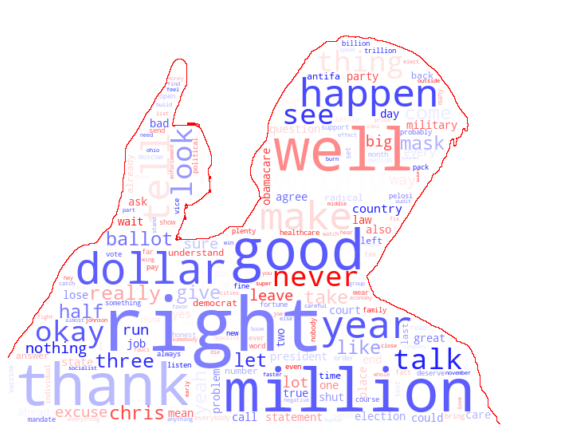

In [11]:
Trump_speaking_token = []

for sentence in Trump_speaking:
    clean_words=[]
    sentence = re.sub('[^a-zA-Z-]+',' ',sentence)
    
    for word in word_tokenize(sentence):
        if len(word)>2 and word.lower() not in stopWords:
            if word not in ['Trump','Biden']:
                word = word.lower()
            clean_words.append(word)
    
    Trump_speaking_token.append(clean_words)
    
for i in range(len(Trump_speaking_token)):
    Trump_speaking_token[i] = [proper_lemmatize(word,tag) for (word,tag) in pos_tag(Trump_speaking_token[i])]
    
Trump_corpus = [*map(lambda x: ' '.join(x) , Trump_speaking_token)]

Trump_tfidfv = TfidfVectorizer(min_df=1).fit(Trump_corpus)
Trump_TFIDF_matrix = Trump_tfidfv.transform(Trump_corpus).toarray()

Trump_index_word = {idx:word for (word,idx) in Trump_tfidfv.vocabulary_.items()}

Trump_TFIDF_sum = Trump_TFIDF_matrix.sum(axis=0)

Trump_frequencies = {Trump_index_word[i]:Trump_TFIDF_sum[i] for i in range(len(Trump_tfidfv.vocabulary_))}


img_path='D:/세미 1차 텍스트 마이닝/formats/'
icon = Image.open(img_path+"trump_mask.png")
mask = Image.new("RGB", icon.size, (255,255,255))
mask.paste(icon,icon)
trump_mask = np.array(mask)

wordcloud = WordCloud(relative_scaling = 0.2,
                      background_color='white',
                      width = 800,
                      height = 800,
                      colormap='bwr',
                      mask=trump_mask,
                      contour_width=1, 
                      contour_color='red'
                     ).generate_from_frequencies(Trump_frequencies)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file(img_path+'Trump_debate_wc.png')

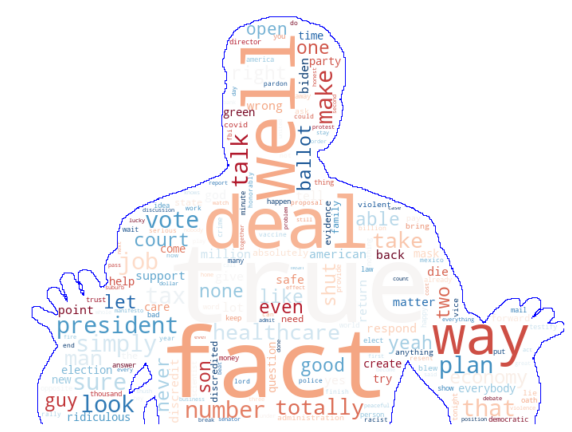

In [12]:
Biden_speaking_token = []

for sentence in Biden_speaking:
    clean_words=[]
    sentence = re.sub('[^a-zA-Z-]+',' ',sentence)
    
    for word in word_tokenize(sentence):
        if len(word)>2 and word.lower() not in stopWords:
            if word not in ['Trump','Biden']:
                word = word.lower()
            clean_words.append(word)
    
    Biden_speaking_token.append(clean_words)
    
for i in range(len(Biden_speaking_token)):
    Biden_speaking_token[i] = [proper_lemmatize(word,tag) for (word,tag) in pos_tag(Biden_speaking_token[i])]
    
Biden_corpus = [*map(lambda x: ' '.join(x) , Biden_speaking_token)]

Biden_tfidfv = TfidfVectorizer(min_df=1).fit(Biden_corpus)
Biden_TFIDF_matrix = Biden_tfidfv.transform(Biden_corpus).toarray()

Biden_index_word = {idx:word for (word,idx) in Biden_tfidfv.vocabulary_.items()}

Biden_TFIDF_sum = Biden_TFIDF_matrix.sum(axis=0)

Biden_frequencies = {Biden_index_word[i]:Biden_TFIDF_sum[i] for i in range(len(Biden_tfidfv.vocabulary_))}


img_path='D:/세미 1차 텍스트 마이닝/formats/'
icon = Image.open(img_path+"biden_mask.png")
mask = Image.new("RGB", icon.size, (255,255,255))
mask.paste(icon,icon)
biden_mask = np.array(mask)

wordcloud = WordCloud(relative_scaling = 0.2,
                      background_color='white',
                      width = 800,
                      height = 800,
                      colormap='RdBu',
                      mask=biden_mask,
                      contour_width=1, 
                      contour_color='blue'
                     ).generate_from_frequencies(Biden_frequencies)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file(img_path+'Biden_debate_wc.png')

### LDA

In [13]:
from sklearn.decomposition import LatentDirichletAllocation

In [14]:
Trump_LDA=LatentDirichletAllocation(n_components=3,learning_method='online',random_state=1120,max_iter=2)
Trump_LDA.fit_transform(Trump_TFIDF_matrix)


word_set = Trump_tfidfv.get_feature_names() 

def get_topics(components, feature_names, n=6):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(2)) for i in topic.argsort()[:-n - 1:-1]])

        
get_topics(Trump_LDA.components_,word_set)

Topic 1: [('never', 10.84), ('make', 10.66), ('well', 10.51), ('happen', 9.83), ('wrong', 9.51), ('come', 8.22)]
Topic 2: [('right', 19.07), ('thing', 7.54), ('mask', 5.8), ('ballot', 5.55), ('see', 5.28), ('true', 5.13)]
Topic 3: [('thank', 26.74), ('million', 13.73), ('yeah', 10.61), ('dollar', 10.57), ('okay', 9.03), ('sure', 8.97)]


In [15]:
Biden_LDA=LatentDirichletAllocation(n_components=3,learning_method='online',random_state=1120,max_iter=2)
Biden_LDA.fit_transform(Biden_TFIDF_matrix)


word_set = Biden_tfidfv.get_feature_names() 

def get_topics(components, feature_names, n=6):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(2)) for i in topic.argsort()[:-n - 1:-1]])

        
get_topics(Biden_LDA.components_,word_set)

Topic 1: [('true', 22.5), ('simply', 5.98), ('number', 5.69), ('look', 5.27), ('economy', 4.97), ('vote', 4.89)]
Topic 2: [('deal', 7.26), ('fact', 5.98), ('tax', 5.66), ('totally', 5.48), ('talk', 5.44), ('way', 5.23)]
Topic 3: [('that', 6.33), ('sure', 5.99), ('president', 4.47), ('court', 4.12), ('ballot', 4.07), ('well', 3.96)]
